# Sqlite Tuning Experiment Analysis Notebook

Begin by running the following command in the integrated terminal in order to generate some trial data:

```sh
mlos_bench --config "./config/cli/local-sqlite-opt.jsonc" --globals "./config/experiments/sqlite-sync-journal-pagesize-caching-experiment.jsonc" --max-iterations 150
```

> See Also: [README.md](./README.md) for further instructions.

## Analyze the results

Next we can start analyzing the autotuning data produced by running the benchmark trials.

In [3]:
# Import some library dependencies.
import json5
import pandas
from matplotlib import pyplot as plt
import seaborn as sns

from mlos_bench.storage import from_config

### Connect using existing mlos_bench configs

In [4]:
storage = from_config(config_file="storage/sqlite.jsonc")

### Load a sqlite Experiment

In [5]:
# Find the experiment_id mentioned in the config file used above.
experiment_globals = "config/experiments/sqlite-sync-journal-pagesize-caching-experiment.jsonc"

with open(experiment_globals, mode='r') as f:
    experiment_id = json5.load(f)['experiment_id']
experiment_id

'sqlite-sync-journal-pagesize-caching-experiment'

## Get all data for one experiment

In [6]:
exp = storage.experiments[experiment_id]
display(exp)

Experiment :: sqlite-sync-journal-pagesize-caching-experiment

In [7]:
# View some of the result data associated with that experiment.
df = exp.results
df.head()

,trial_id,ts_start,ts_end,config_id,status,config.cache_size,config.journal_mode,config.journal_size_limit,config.mmap_size,config.page_size,...,result.Socket messages received,result.Socket messages sent,result.Swaps,result.System time (seconds),result.Throughput (requests/second),result.User time (seconds),result.Voluntary context switches,result.isolation,result.scalefactor,result.terminals
0,0,2023-10-10 21:24:47.492927,2023-10-10 21:25:49.387720,710,SUCCEEDED,1,delete,-1,-1,4096,...,0,0,0,3.61,24.916242,5.40,117445,TRANSACTION_SERIALIZABLE,1,1
1,1,2023-10-10 21:25:49.431382,2023-10-10 21:26:51.449788,711,SUCCEEDED,1656398469,truncate,1633227268,363162755,2048,...,0,0,0,3.90,136.398333,10.37,116366,TRANSACTION_SERIALIZABLE,1,1
2,2,2023-10-10 21:26:51.496642,2023-10-10 21:27:53.904873,712,SUCCEEDED,1281136238,off,704594,779126884,2048,...,0,0,0,2.21,143.849273,11.09,101870,TRANSACTION_SERIALIZABLE,1,1
3,3,2023-10-10 21:27:53.953987,2023-10-10 21:28:56.350663,713,SUCCEEDED,948829517,wal,1120228729,1951308613,8192,...,0,0,0,1.66,138.747777,11.44,93873,TRANSACTION_SERIALIZABLE,1,1
4,4,2023-10-10 21:28:56.401313,2023-10-10 21:29:59.232525,714,SUCCEEDED,699030920,persist,2027784438,2120909557,8192,...,0,0,0,12.76,2049.177860,56.30,76037,TRANSACTION_SERIALIZABLE,1,1


In [8]:
# View some of the data associated with one of those trials.
# (includes metadata, config data, and results metrics data)
display(df.loc[1])

trial_id                                                                                              1
ts_start                                                                     2023-10-10 21:25:49.431382
ts_end                                                                       2023-10-10 21:26:51.449788
config_id                                                                                           711
status                                                                                        SUCCEEDED
config.cache_size                                                                            1656398469
config.journal_mode                                                                            truncate
config.journal_size_limit                                                                    1633227268
config.mmap_size                                                                              363162755
config.page_size                                                

### Plot the results

#### Plot the behavior of the optimizer

In [11]:
# TODO:
# 1. plot of the optimizer's best config found so far (convergence rate of the optimizer)
# 2. plot of the performance of each config the optimizer found (search behavior of the optimizer)

#### Plot the results of one metric vs. another for some tunable

The intent is to explore parameter importance and impact on different metrics (both application performance and system resource usage).

In [9]:
# Categorical tunable to consider:
CATEGORY = "config.synchronous"

# A system resource metric to analyze.
METRIC = "result.File system outputs"

# Which performance metric to plot on the Y-axis.
SCORE = "result.90th Percentile Latency (microseconds)"

/home/vscode/.conda/envs/mlos/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vscode/.conda/envs/mlos/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vscode/.conda/envs/mlos/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vscode/.conda/envs/mlos/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

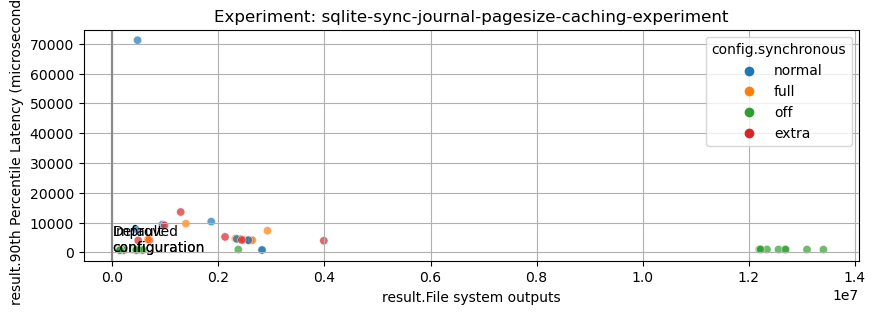

In [10]:
plt.rcParams["figure.figsize"] = (10, 3)

sns.scatterplot(data=df, x=METRIC, y=SCORE, hue=CATEGORY, marker='o', alpha=0.7)

plt.axvline(x=8, color="#888888", alpha=0.8)
plt.text(8.5, 143, "Improved\nconfiguration", horizontalalignment='left', size='medium', color='black')

plt.axvline(x=20, color="#888888", alpha=0.8)
plt.text(20.5, 143, "Default\nconfiguration", horizontalalignment='left', size='medium', color='black')

plt.title("Experiment: " + exp.exp_id)
plt.grid()
plt.show()